*Import the data and the packages*

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binomtest
from data_personal_example import transaction_data_file, block_data_file,  \
large_pre_gas_prices_file, suite_spot_txn, suite_spot_blx, new_post_eip_txn, \
new_post_eip_blx, new_post_eip_rcpts


#Read in the data, use your own machines specific path as you see fit
post_transaction_data=pd.read_csv(transaction_data_file)
post_block_data=pd.read_csv(block_data_file)
#read in the data and convert it to a list for better calculation speed
large_pre_gas_prices=list(pd.read_csv(large_pre_gas_prices_file).gas_price)
#read in sweet spot data
suite_txn=pd.read_csv(suite_spot_txn)
suite_blx=pd.read_csv(suite_spot_blx)


##can be disregarded, basically a failed experiment
#read in the spike free data
new_txn=pd.read_csv(new_post_eip_txn)
new_blx=pd.read_csv(new_post_eip_blx)
new_rpcts=pd.read_csv(new_post_eip_rcpts)

*Adding the gas limits into the dataframe*

first we add the gas limits into the transaction dataframe, as well as add the gas limits and base fee back into the dataframe

In [2]:
#Get the block number and gas limits and base fee from the dataset
post_block_number=list(post_block_data.block_number)
post_gas_limit=list(post_block_data.gas_limit)
post_base_fee=list(post_block_data.base_fee_per_gas)
#initialize a dictionary to assign gas limits and base fee to the transaction data
gas_limit_tracker={}
base_fee_tracker={}


#makes a dicionary with the key being the block number and the 
#value being the gas limits and base fee, because this will allow us to 
#easily assign a gas limit and base fee to the transaction going forward
for i in range(len(post_block_number)):
    gas_limit_tracker[post_block_number[i]]=post_gas_limit[i]
    base_fee_tracker[post_block_number[i]]=post_base_fee[i]
    
    
##get the block numbers from the transaction data
post_transaction_block_numbers=list(post_transaction_data.block_number)


#initialize a list for the purpose of saving the gas limits that will 
#be assigned to the transaction data and assign the correct information
gas_limits_for_transaction_data=[gas_limit_tracker[x] for x in post_transaction_block_numbers]
base_fee_for_transaction_data=[base_fee_tracker[x] for x in post_transaction_block_numbers]

    
#add the column into the dataframe
#transaction_data['gas_limit']=gas_limits_for_transaction_data
post_transaction_data['base_fee']=base_fee_for_transaction_data


# The final step is to remove the NA's from then dataframe, from testing of the 
# dataset, i have found that the max priority fee per gas and the max fee per gas
# have the the same number of NA's -this can be oberved with the line 
# np.sum(transaction_data.isna())- that we can remove the NA's with the line...
post_transaction_data= \
post_transaction_data[pd.notnull(post_transaction_data.max_fee_per_gas)]

*Rescaling the gas prices*

 now we need to add another column to revert the gas price into a metric that we 
can compare to the pre EIP 1559 data. to do this, we will need to work under the
 assumption that gas limits represent the same metric that they do in the pre EIP 
 1559 network (which is an assumption that the previous paper made that we will 
 continue in this proposal). then, we see that the user bid has a specific value 
 in the post EIP 1559 section which is min(base fee + tip , max tip), while in the pre EIP section the userbid is equal 
 to gas price * gas limit. Therefore, if we set these metrics to be equal, we can 
 solve for the equivilent of the gas prices in the post EIP section, giving us an ultimate answer of $\frac{min(base \: fee \: + \: tip, \:  max \: fee)}{gas \: limit}  \: =equivilent \: to \: pre \: EIP \: gas \: price$.

In [3]:
#get all the values...
b_fee=list(post_transaction_data.base_fee)
g_limit=list(post_transaction_data.gas)
m_fee=list(post_transaction_data.max_fee_per_gas)
tip=list(post_transaction_data.max_priority_fee_per_gas)


#Evaluate and store the rescaled gas prices
rescaled_gas_prices=[min(b_fee[x]+tip[x],m_fee[x])/g_limit[x] for \
                    x in range(len(b_fee))]

#transaction_data=transaction_data['rescaled_gas_prices']=rescaled_gas_prices


*Comparing variance*

We will be comparing the variance in two ways, first, we will be simply taking the variance of the entire dataset, then we will run a simulation where the code will randomly take sets of 500 from both the pre and post EIP 1559 data and compare the variance in a simulation of many times and reports the results.

*Clean up the data for comparison, remove outliers*

I will be using the "03_22_03_26.csv" dataset in the CAMCOS google drive for the largest portion of data available, for both the 03_22_03_26.csv dataset and the suite spot dataset I'm going to use 40,000 results for a more appropriate comparison of variance.

*First we will clean up the pre EIP dataset*

In [4]:
#randomly generate 40000 indexes for the larger dataset
pre_index=np.random.uniform(0,len(large_pre_gas_prices)-2,40000)
pre_index=[round(x) for x in pre_index]


#assign values with the random indexes
pre_gas_prices=[large_pre_gas_prices[x] for x in pre_index]
    

#gets 10% quantile and 90% quantile for both pre and post 
#for later use in removing outliers
pre_up_lim=np.quantile(pre_gas_prices,0.9)
pre_lo_lim=np.quantile(pre_gas_prices,0.1)
post_up_lim=np.quantile(rescaled_gas_prices,0.9)
post_lo_lim=np.quantile(rescaled_gas_prices,0.1)


#Remove the outliers, save the results in two variables that
#will be our final variables
pre_gas=[x for x in pre_gas_prices if (x<pre_up_lim) & (x>pre_lo_lim)]
post_gas=[x for x in rescaled_gas_prices if (x<post_up_lim) & (x>post_lo_lim)]

*Now to clean uo the suite spot data*

In [5]:
#get gas prices
suite_gas_prices=list(suite_txn.gas_price)

#randomly generate 40000 indexes for the larger dataset
suite_index=np.random.uniform(0,len(suite_gas_prices)-2,40000)
suite_index=[round(x) for x in suite_index]


#assign values with the random indexes
suite_gas_prices=[suite_gas_prices[x] for x in suite_index]
    

#gets 10% quantile and 90% quantile for both suite gas
suite_up_lim=np.quantile(suite_gas_prices,0.9)
suite_lo_lim=np.quantile(suite_gas_prices,0.1)



#Remove the outliers, save the results
suite_gas=[x for x in suite_gas_prices if (x<suite_up_lim) & (x>suite_lo_lim)]


*Simulation 1: non-ideal data*

This simulation will be done with a normalization method, where for each unit i in n we take $\frac{n_i}{(n_i)^2}$ to try to account for the discrepency of the size of the units

In [6]:
##a function to normalize the gas price data via dividing by the square of the mean
def my_normalizer(my_list):
    
#    my_mean=np.mean(my_list)**2
    return [x/(x**2) for x in my_list]





#a function designed to take two lists, pre and post EIP respectively,
#and return False if post is bigger and True if post is smaller
def variance_checker(pre,post):
    if np.var(pre)<np.var(post):
        return False
    else:
        return True
    
    
#a function desinged to take two lists, along with a specefied integer, and then
#generate an amount of random indexes associated with indexes to the two lists 
#in the amount of the number specified
def random_index_generator(list1,list2,number):
    result1=list(np.random.uniform(0,len(list1)-2,number))
    result1=[round(x) for x in result1]
    result2=list(np.random.uniform(0,len(list2)-2,number))
    result2=[round(x) for x in result2]
    return [result1,result2]


#declare a variable to represent the number of trials to take place in the simulation 
trials=10000
#initialize a list to represent the output of the simulation
results=[]


#this code runs a simulation that randomly takes 500 observations from each dataset and 
#records the percentage of times the variance is smaller in the post EIP dataset
for i in range(trials):
    my_index=random_index_generator(pre_gas,post_gas,500)
    index_1=my_index[0]
    index_2=my_index[1]
    my_pre_gas=my_normalizer([pre_gas[x] for x in index_1])
    my_post_gas=my_normalizer([post_gas[x] for x in index_2])
    results.append(variance_checker(my_pre_gas,my_post_gas))

    
#output results of simulation and simple variance of the two datasets
print("the variance in the post EIP-1559 data is " +  str(np.var(my_normalizer(post_gas))) + \
      " and the variance in the pre EIP-1559 data is " + str(np.var(my_normalizer(pre_gas))) + \
      ". the percentage of times the variance was lower in post EIP-1559 data " + \
      "durring our simulation after normalizing was " +
      str(int(round((sum(results)/len(results))*100))) + '%. Note, the data had ' + \
      "to be normalized to make up for the discrepency of size in the units")


#output summary stats of pre and post EIP gas prices
print('\n Some summary stats: \n \t Pre-EIP: \n')
print('\t Max: ' + str(np.max(pre_gas)))
print('\n \t Min: ' + str(np.min(pre_gas)))
print('\n \t Mean: ' + str(np.mean(pre_gas)))
print('\n \t Variance: ' + str(np.var(pre_gas)))
print('\n \t Quartile 25,50,75: ' + str(np.quantile(pre_gas,0.25)) + "," + \
      str(np.quantile(pre_gas,0.5)) + ',' +  str(np.quantile(pre_gas,0.75)))
print('\n \n \t Post-EIP:')
print('\t Max: ' + str(np.max(post_gas)))
print('\n \t Min: ' + str(np.min(post_gas)))
print('\n \t Mean: ' + str(np.mean(post_gas)))
print('\n \t Variance: ' + str(np.var(post_gas)))
print('\n \t Quartile 25,50,75: ' + str(np.quantile(post_gas,0.25)) + "," + \
      str(np.quantile(post_gas,0.5)) + ',' +  str(np.quantile(post_gas,0.75)))

the variance in the post EIP-1559 data is 4.867035345448965e-12 and the variance in the pre EIP-1559 data is 1.872673188266447e-24. the percentage of times the variance was lower in post EIP-1559 data durring our simulation after normalizing was 0%. Note, the data had to be normalized to make up for the discrepency of size in the units

 Some summary stats: 
 	 Pre-EIP: 

	 Max: 256800000000

 	 Min: 107000000001

 	 Mean: 164940109763.65692

 	 Variance: 1.3905628672736373e+21

 	 Quartile 25,50,75: 135000000000.0,158000000000.0,189000000000.0

 
 	 Post-EIP:
	 Max: 2496463.8959047617

 	 Min: 132685.97152251133

 	 Mean: 617233.1705626977

 	 Variance: 295061619654.1383

 	 Quartile 25,50,75: 178221.58082857143,413566.0087105776,828456.6181150794


*Simulation 2: suite spot data*

In [7]:
#declare a variable to represent the number of trials to take place in the simulation 
trials=10000
#initialize a list to represent the output of the simulation
results=[]


#this code runs a simulation that randomly takes 500 observations from each dataset and 
#records the percentage of times the variance is smaller in the post EIP dataset
for i in range(trials):
    my_index=random_index_generator(suite_gas,post_gas,500)
    index_1=my_index[0]
    index_2=my_index[1]
    my_suite_gas=my_normalizer([suite_gas[x] for x in index_1])
    my_post_gas=my_normalizer([post_gas[x] for x in index_2])
    results.append(variance_checker(my_suite_gas,my_post_gas))

    
#output results of simulation and simple variance of the two datasets
print("the variance in the post EIP-1559 data is " +  str(np.var(my_normalizer(post_gas))) + \
      " and the variance in the 'suite spot' EIP-1559 data is " + str(np.var(my_normalizer(suite_gas))) + \
      ". the percentage of times the variance was lower in post EIP-1559 data " + \
      "durring our simulation after normalizing was " +
      str(int(round((sum(results)/len(results))*100))) + '%. Note, the data had ' + \
      "to be normalized to make up for the discrepency of size in the units")


#output summary stats of pre and post EIP gas prices
print('\n Some summary stats: \n \t Pre-EIP: (suite spot) \n')
print('\t Max: ' + str(np.max(suite_gas)))
print('\n \t Min: ' + str(np.min(suite_gas)))
print('\n \t Mean: ' + str(np.mean(suite_gas)))
print('\n \t Variance: ' + str(np.var(suite_gas)))
print('\n \t Quartile 25,50,75: ' + str(np.quantile(suite_gas,0.25)) + "," + \
      str(np.quantile(suite_gas,0.5)) + ',' +  str(np.quantile(suite_gas,0.75)))
print('\n \n \t Post-EIP:')
print('\t Max: ' + str(np.max(post_gas)))
print('\n \t Min: ' + str(np.min(post_gas)))
print('\n \t Mean: ' + str(np.mean(post_gas)))
print('\n \t Variance: ' + str(np.var(post_gas)))
print('\n \t Quartile 25,50,75: ' + str(np.quantile(post_gas,0.25)) + "," + \
      str(np.quantile(post_gas,0.5)) + ',' +  str(np.quantile(post_gas,0.75)))

the variance in the post EIP-1559 data is 4.867035345448965e-12 and the variance in the 'suite spot' EIP-1559 data is 5.054292252897253e-23. the percentage of times the variance was lower in post EIP-1559 data durring our simulation after normalizing was 0%. Note, the data had to be normalized to make up for the discrepency of size in the units

 Some summary stats: 
 	 Pre-EIP: (suite spot) 

	 Max: 230494400492

 	 Min: 32000000673

 	 Mean: 77949469477.3573

 	 Variance: 2.162196823572163e+21

 	 Quartile 25,50,75: 45000000000.0,60000000000.0,98000000000.0

 
 	 Post-EIP:
	 Max: 2496463.8959047617

 	 Min: 132685.97152251133

 	 Mean: 617233.1705626977

 	 Variance: 295061619654.1383

 	 Quartile 25,50,75: 178221.58082857143,413566.0087105776,828456.6181150794


*Implementation of the c-test*

This method works by approximating the joint probability distribution of X_1 and X_2 as a binomial distribution, where in the binomial distibtion, the x parameter is lambda_1 (from X_1), the n parameter is lambda_1+lambda_2, and the p parameter is n_1/(n_1+n_2) This test finds the p-value corresponding to the ratio lambda_1/lambda_2, the reasoning being that if the ratio is large, then that means lambda 1 is larger than lambda 2 (and thus that variance of the pre EIP gas price is larger than the variance of the post EIP gas price) to a statistically significant degree. Hence, we perform a "greater than" binomial test to determine of the if the variance is smaller in the post EIP framework.

This method was retrieved from the following sources: 

1. https://stats.stackexchange.com/questions/109402/c-test-for-comparing-poisson-means-in-scipy

2. https://cran.r-project.org/web/packages/rateratio.test/vignettes/rateratio.test.pdf

*The first implementation will be conducted on the non-ideal data*

In [8]:
##grab the parameters for the test
my_x=int(np.mean(pre_gas))
my_n=int(np.mean(pre_gas))+int(np.mean(post_gas))
my_p=len(pre_gas)/(len(pre_gas)+len(post_gas))


#print the results of the test to the user
print('\n \n') 
print(binomtest((my_x),my_n,my_p,alternative='greater'))
print('\n \n' + 'This result means that we reject the null hypothesis, meaning that the' + \
      ' variance in the pre EIP framework \n' + 'is larger than the post EIP to a ' +\
      'statistically significant degree' )


 

BinomTestResult(k=164940109763, n=164940726996, alternative='greater', proportion_estimate=0.9999962578496455, pvalue=0.0)

 
This result means that we reject the null hypothesis, meaning that the variance in the pre EIP framework 
is larger than the post EIP to a statistically significant degree


/Users/jacobmcgraw/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:75: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)


*The second implimentation of the c-test will be on the ideal data*

In [9]:
##grab the parameters for the test
my_x=int(np.mean(suite_gas))
my_n=int(np.mean(suite_gas))+int(np.mean(post_gas))
my_p=len(suite_gas)/(len(suite_gas)+len(post_gas))


#print the results of the test to the user
print('\n \n') 
print(binomtest((my_x),my_n,my_p,alternative='greater'))
print('\n \n' + 'This result means that we reject the null hypothesis, meaning that the' + \
      ' variance in the pre EIP framework (suite spot) \n' + 'is larger than the post EIP to a ' +\
      'statistically significant degree' )


 

BinomTestResult(k=77949469477, n=77950086710, alternative='greater', proportion_estimate=0.9999920816893726, pvalue=0.0)

 
This result means that we reject the null hypothesis, meaning that the variance in the pre EIP framework (suite spot) 
is larger than the post EIP to a statistically significant degree


To get a better result from the variance checker, we will omit the blocks that are from the spikes. The results seem to indicate that the most severe spikes in the first 8000 observations are from 12965850 - 12966400, 12966100 - 12966650, and 12972200 - 12972600

In [10]:
#display(new_txn)
#display(new_blx)
#display(new_rpcts)


new_rpcts=new_rpcts.rename(columns={'transaction_hash':'hash'})

#display(new_rpcts)
#new_txn=
new_txn=pd.merge(new_rpcts,new_txn,on='hash')



#display(new_txn)
#display(new_blx)

base_fee_tracker={}

my_blocks=list(new_blx.number)
my_b_fee=list(new_blx.base_fee_per_gas)


for i in range(len(my_blocks)):
    base_fee_tracker[my_blocks[i]]=my_b_fee[i]
    
b_fee_for_txn=[]
for i in new_txn.block_number:
    b_fee_for_txn.append(base_fee_tracker[i])
    
    
new_txn['base_fee_per_gas']=b_fee_for_txn


new_txn=new_txn[pd.notnull(new_txn.max_priority_fee_per_gas)]



#display(new_txn)

#new_txn['valuations']=np.min()

my_max_fee=list(new_txn.max_fee_per_gas)
my_tip=list(new_txn.max_priority_fee_per_gas)
my_b_fee=list(new_txn.base_fee_per_gas)
my_g_limit=list(new_txn.gas)



rescaled_gas_prices=[]

#for i in range(len(my_max_fee)):
#    rescaled_gas_prices.append(min(my_b_fee[i] + my_tip[i])/my_gas_limit[i])



#rescaled_gas_prices=[min(my_b_fee[x] + my_tip[x] , my_max_fee[x]) / my_gas_limit[x] 
#for x in range(len(my_g_limit))]

#rescaled_gas_prices=[min(b_fee[x]+tip[x],m_fee[x])/g_limit[x] for \
#                    x in range(len(b_fee))]

for i in range(len(my_max_fee)):
    my_min=min(my_b_fee[i] + my_tip[i] , my_max_fee[i])
    price=my_min/my_g_limit[i]
    rescaled_gas_prices.append(price)
    
    
new_txn['rescaled_gas_prices']=rescaled_gas_prices
display(new_txn)
#df[pd.notnull(df.column_of_interest)]
#rescaled_gas_prices[0:2]
#print(len(my_max_fee),len(my_tip),len(my_b_fee),len(my_g_limit))

,hash,gas_used,block_number,value,gas,gas_price,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,base_fee_per_gas,rescaled_gas_prices
197,0xf03bd87c159a0a497949480b2bbb0de7e23dce94cec1...,45038,12965602,1000000000000000000,45038,83706455346,1.359278e+11,2.299540e+10,2,60711056639,1.858574e+06
212,0xfba633d9e7551a4440f5b6e35906d6125978d53e23ed...,110856,12965602,0,148594,83000000000,8.300000e+10,8.300000e+10,2,60711056639,5.585690e+05
414,0xa8fd938ae7ae741aa491cd6c3197667102b0b29ac8e2...,37271,12965602,0,299408,69731541406,6.973154e+10,6.973154e+10,2,60711056639,2.328981e+05
456,0xf1c71974ee378692cdb32e8032e365b0acf4de2cf4ae...,122414,12965602,113222162739578599,180340,67535512656,1.221756e+11,6.824456e+09,2,60711056639,3.744899e+05
458,0xa8a1f19ee0772fb7de745eb10b21873eab1da5d7d204...,21000,12965602,4700000000000000000,21000,67535512656,1.221756e+11,6.824456e+09,2,60711056639,3.215977e+06
...,...,...,...,...,...,...,...,...,...,...,...
1843740,0x9df9a7b26360e0a74a4b5169e22a1f464d982d7cce84...,21000,12975499,1578144170000000000,21000,41761910280,8.000000e+10,7.000000e+09,2,34761910280,1.988662e+06
1843742,0xcfe656a58141b62303c6780b8059767e62bcdf3d9a32...,21000,12975499,16661600000000000,21000,41761910280,8.000000e+10,7.000000e+09,2,34761910280,1.988662e+06
1843769,0xd6c4ea99cd88d81d1d0e54ec9247295d3baafef4084c...,30416,12975499,0,36027,39672524207,6.936067e+10,4.910614e+09,2,34761910280,1.101189e+06
1843770,0x9faf8533bf95d6a99e3974099598024cbc7f65c73cd3...,21000,12975499,6100000000000000,21000,39672524207,6.936067e+10,4.910614e+09,2,34761910280,1.889168e+06


start: 12965400 <br>
spike 1: 12966050:12966400 <br>
spike 2: 12971900:12973400 <br>
end: 12975400

In [11]:
##NOTE:
#these two lines need to be run on the first new run of this code 
#on your machine, after that, comment them out

new_txn=new_txn.sort_values(by=['block_number'])
new_txn=new_txn.set_index('block_number')


r1=new_txn.loc[12965400:12966050]
r1=r1.reset_index()
r2=new_txn.loc[12966400:12971900]
r2=r2.reset_index()
r3=new_txn.loc[12973400:12975400]
r3=r3.reset_index()

#display(r1)
#display(r2)
#display(r3)

r1_m_r2_m_r3=pd.concat([r1,r2,r3],axis=0)
#r1_m_r2_m_r3.loc[0].hash

Now to replicate the results of the variance checker ommiting the blocks with spikes. The first thing we need to do is randomly grab 80000 observations from the pre-eip framework and then remove outliers.

In [12]:
def random_index_generator_2(my_list,num_of_indexes):
    
    my_max=len(my_list)-1
    result=np.random.uniform(0,my_max,num_of_indexes)
    return [round(x) for x in result]

len(large_pre_gas_prices)


my_indexes=random_index_generator_2(large_pre_gas_prices,80000)

pre_eip_observations=[large_pre_gas_prices[x] for x in my_indexes]
post_eip_observations=list(r1_m_r2_m_r3.rescaled_gas_prices)




##remove outliers
pre_up=np.percentile(pre_eip_observations,90)
pre_lo=np.percentile(pre_eip_observations,10)
true_pre_eip=[x for x in pre_eip_observations if (x < pre_up) & (x > pre_lo)]

post_up=np.percentile(post_eip_observations,90)
post_lo=np.percentile(post_eip_observations,10)
true_post_eip=[x for x in post_eip_observations if (x < post_up) & (x > post_lo)]
print(r1_m_r2_m_r3.iloc[0])
print(r1_m_r2_m_r3.hash.iloc[0])

block_number                                                         12965401
hash                        0x272fedf18b095d9d59d805ccf724200675c757fa14fd...
gas_used                                                               254766
value                                                                       0
gas                                                                    448229
gas_price                                                        102000000000
max_fee_per_gas                                                102000000000.0
max_priority_fee_per_gas                                       102000000000.0
transaction_type                                                            2
base_fee_per_gas                                                  94973980561
rescaled_gas_prices                                             227562.250546
Name: 0, dtype: object
0x272fedf18b095d9d59d805ccf724200675c757fa14fdc212b909e87abf566831


Now I will replicate the variance checker code but with the newest and cleanest data

In [13]:
#declare a variable to represent the number of trials to take place in the simulation 
trials=10000
#initialize a list to represent the output of the simulation
results=[]


##PRE:true_pre_eip
##POST:true_post_eip



#this code runs a simulation that randomly takes 500 observations from each dataset and 
#records the percentage of times the variance is smaller in the post EIP dataset
for i in range(trials):
    my_index=random_index_generator(true_pre_eip,true_post_eip,500)
    index_1=my_index[0]
    index_2=my_index[1]
    my_pre_gas=my_normalizer([true_pre_eip[x] for x in index_1])
    my_post_gas=my_normalizer([true_post_eip[x] for x in index_2])
    results.append(variance_checker(my_pre_gas,my_post_gas))

    
#output results of simulation and simple variance of the two datasets
print("the variance in the post EIP-1559 (no spike) data is " +  str(np.var(my_normalizer(true_post_eip))) + \
      " and the variance in the pre EIP-1559 data is " + str(np.var(my_normalizer(true_pre_eip))) + \
      ". the percentage of times the variance was lower in post EIP-1559 data " + \
      "durring our simulation after normalizing was " +
      str(int(round((sum(results)/len(results))*100))) + '%. Note, the data had ' + \
      "to be normalized to make up for the discrepency of size in the units")


#output summary stats of pre and post EIP gas prices
print('\n Some summary stats: \n \t Pre-EIP: \n')
print('\t Max: ' + str(np.max(true_pre_eip)))
print('\n \t Min: ' + str(np.min(true_pre_eip)))
print('\n \t Mean: ' + str(np.mean(true_pre_eip)))
print('\n \t Variance: ' + str(np.var(true_pre_eip)))
print('\n \t Quartile 25,50,75: ' + str(np.quantile(true_pre_eip,0.25)) + "," + \
      str(np.quantile(true_pre_eip,0.5)) + ',' +  str(np.quantile(true_pre_eip,0.75)))
print('\n \n \t Post-EIP: (no spike)')
print('\t Max: ' + str(np.max(true_post_eip)))
print('\n \t Min: ' + str(np.min(true_post_eip)))
print('\n \t Mean: ' + str(np.mean(true_post_eip)))
print('\n \t Variance: ' + str(np.var(true_post_eip)))
print('\n \t Quartile 25,50,75: ' + str(np.quantile(true_post_eip,0.25)) + "," + \
      str(np.quantile(true_post_eip,0.5)) + ',' +  str(np.quantile(true_post_eip,0.75)))

the variance in the post EIP-1559 (no spike) data is 5.477156510589586e-12 and the variance in the pre EIP-1559 data is 1.9090414429887653e-24. the percentage of times the variance was lower in post EIP-1559 data durring our simulation after normalizing was 0%. Note, the data had to be normalized to make up for the discrepency of size in the units

 Some summary stats: 
 	 Pre-EIP: 

	 Max: 257999999999

 	 Min: 107000001347

 	 Mean: 165049967156.59656

 	 Variance: 1.4185144696329048e+21

 	 Quartile 25,50,75: 134000000000.0,158000000000.0,190000000000.0

 
 	 Post-EIP: (no spike)
	 Max: 2232812.845190476

 	 Min: 120756.24817652385

 	 Mean: 560914.3235205642

 	 Variance: 269727015799.2569

 	 Quartile 25,50,75: 178221.58082857143,304436.4367272502,821197.2743272728


plot the base fee just to make sure no spikes got in 

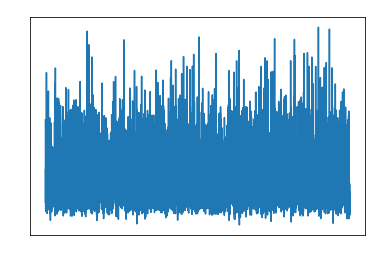

In [14]:
my_base_fee=list(set(list(r1_m_r2_m_r3.base_fee_per_gas)))
my_x=list(range(len(my_base_fee)))


fig = plt.figure()
ax = plt.axes()


ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y',colors='white')
ax.title.set_color('white')
plt.plot(my_x,my_base_fee)